### Problem Overview

As Star Wars data nerds, we have a few questions about the Universe. We don’t really like wikis, but we do love APIs, code, charts, and graphs!

We’ve seen the Star Wars API (https://swapi.co), and its data seem useful. However, it leaves us with a few specific questions that we need answered in visual form:
    1. It seems like there is quite a variety of heights in the Star Wars Universe. Show us the distribution of heights across gender, homeworld, and species.
    2. The Original Trilogy and the Prequel Trilogy both featured men in leading roles and women in supporting roles, but the Sequel Trilogy features a leading woman. What is the distribution of genders across the films?
    3. Back to our difficult-to-explain interest in heights: can you find and visualize a linear regression that clearly explains the height of an individual? 
    
Using a programming language and/or framework of your choice, write a program that gives us insight into these questions. We like visualizations (e.g. charts and graphs), not tables or lists of numbers. If you have any other ideas, questions or insights from the data, we’d love o see those as well!

In [1]:
# for accessing the API
import requests 
import json 
import time
# data wrangling
import pandas as pd 
import numpy as np
import os
# graphing
import matplotlib.pyplot as plt
from scipy.stats import norm
# model selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# functions I've moved elsewhere
from src.data_analysis import web_utilities
from src.data_analysis import df_utilities

%matplotlib inline 

## Navigating the API

There are a few different ways to access the API. The resource types are:
 - Film, People, Planets, Species, Starships, and Vehicles

Film will give us information about each film (title, opening crawl, director, etc.), people will give us information about a person within the Star Wars universe (name, height, eye color, etc.), and so on. Here it makes sense to focus on the "people" resource, since we're being asked very "people-centric" questions. 

As you can see below, this is a very nice API. If we make a request to the root "People" url, we're given a json object that contains:
- count: the number of "people" resources
- next: the url of the next chunk
- previous: the url of the previous chunk
- results: a json containing a list of dicts. Each dict contains information about one person

In [2]:
url = 'http://swapi.co/api/people/'
a = web_utilities.get_json(url)
print(a.keys(),'\n')
print('Next: {}'.format(a['next']), 
      'Previous: {}'.format(a['previous']), 
      'Count: {}'.format(a['count']), sep='\n')

Visiting url: http://swapi.co/api/people/
dict_keys(['count', 'next', 'previous', 'results']) 

Next: https://swapi.co/api/people/?page=2
Previous: None
Count: 87


In [3]:
a['results']

[{'name': 'Luke Skywalker',
  'height': '172',
  'mass': '77',
  'hair_color': 'blond',
  'skin_color': 'fair',
  'eye_color': 'blue',
  'birth_year': '19BBY',
  'gender': 'male',
  'homeworld': 'https://swapi.co/api/planets/1/',
  'films': ['https://swapi.co/api/films/2/',
   'https://swapi.co/api/films/6/',
   'https://swapi.co/api/films/3/',
   'https://swapi.co/api/films/1/',
   'https://swapi.co/api/films/7/'],
  'species': ['https://swapi.co/api/species/1/'],
  'vehicles': ['https://swapi.co/api/vehicles/14/',
   'https://swapi.co/api/vehicles/30/'],
  'starships': ['https://swapi.co/api/starships/12/',
   'https://swapi.co/api/starships/22/'],
  'created': '2014-12-09T13:50:51.644000Z',
  'edited': '2014-12-20T21:17:56.891000Z',
  'url': 'https://swapi.co/api/people/1/'},
 {'name': 'C-3PO',
  'height': '167',
  'mass': '75',
  'hair_color': 'n/a',
  'skin_color': 'gold',
  'eye_color': 'yellow',
  'birth_year': '112BBY',
  'gender': 'n/a',
  'homeworld': 'https://swapi.co/api/pl

# People Attributes
![people_attribute info](./assets/images/people_attributes.png)

There are 87 people, so we can easily load all of the People data into memory. It would be nice to put these into a Pandas DataFrame, but the data will need to be wrangled a little bit first. We can drop "url", "created", and "edited". The "films", "species", "starships", and "vehicles" attributes are returned arrays, so we'll need to figure out some way to make these into valid columns. For "films" for example, we might have a column for each movie and a value of True or False for each row, indicating if the person was present or not. 

## Writing data to csv

With a free resource like this API, it's courteous to make only the requests we need. Here I have a function that builds a dataframe, and then saves it to a .csv file for future use, so I don't need to query the API every time I rerun this notebook. There's also a built-in delay of a few seconds between requests.

In [4]:
if not os.path.exists('./assets/dataframe.csv'):
    df = df_utilities.build_dataframe()
    df = df_utilities.cleanup(df)
    df.to_csv('./assets/dataframe.csv')
else: 
    df = pd.read_csv('./assets/dataframe.csv', index_col = 0)
    print("Dataframe loaded from .csv!")
df.head()

Dataframe loaded from .csv!


,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


# Data Visualization

The data is now in a Pandas Dataframe. This gives us a lot of useful tools. We can take advantage of some of the things that make Numpy powerful (vectorization, broadcasting, etc), while gaining a lot of convenience (labeled columns, easier to deal with missing values, etc.). 

## Question 1

It seems like there is quite a variety of heights in the Star Wars Universe. Show us the distribution of heights across gender, homeworld, and species.

From a quick look at the data, we can see that there are 62 males, 19 females, and ~5 with no gender. That's a small enough sample size that we should probably just drop ignore those values.

In [5]:
from src.data_analysis.jupyter_functions import *

print_unique_counts(df, 'gender')

gender                   counts                  |gender                   counts              
------------------------------------------------------------------------
male                     counts: 62              |no gender                counts: 5           
female                   counts: 19              |hermaphrodite            counts: 1           
NaN                      counts: 0           


In [6]:
male_heights = df.height[get_height_mask(df, 'male')]
female_heights = df.height[get_height_mask(df, 'female')]

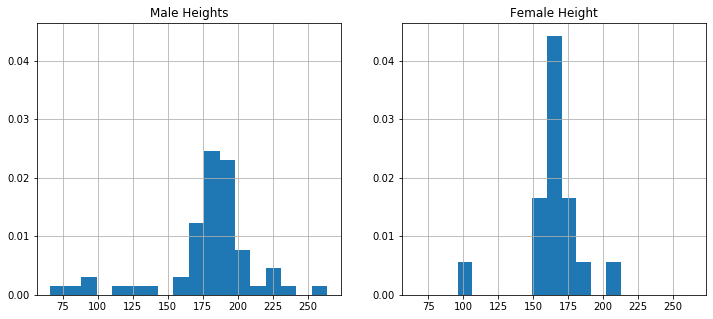

In [7]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ay = fig.add_subplot(122, sharey=ax, sharex=ax)
male_heights.hist(bins = 18, ax=ax, density=True)
female_heights.hist(bins = 11, ax=ay, density=True)
ax.set_title('Male Heights')
ay.set_title('Female Height')
plt.show()

In [8]:
fig.savefig('assets/images/height_vs_gender.jpg')

## Heights across Homeworlds

Looking at the data down below, there are a lot of worlds with only one datapoint. From the looks of things, we'll only be able to work with Naboo and Tatooine. At a stretch we might get something out of the worlds with three datapoints: Coruscant, Kamino, and Alderaan. Since the data visualization phase is purely for illustrative purposes, it can't hurt to throw them in.

In [9]:
print_unique_counts(df,'homeworld')
worlds,world_counts = np.unique(df.homeworld, return_counts=True)
populous_worlds = worlds[np.where(world_counts>2)]
populous_worlds

homeworld                counts                  |homeworld                counts              
------------------------------------------------------------------------
Naboo                    counts: 11              |Champala                 counts: 1           
unknown                  counts: 10              |Cerea                    counts: 1           
Tatooine                 counts: 10              |Iktotch                  counts: 1           
Coruscant                counts: 3               |Troiken                  counts: 1           
Kamino                   counts: 3               |Kalee                    counts: 1           
Alderaan                 counts: 3               |Trandosha                counts: 1           
Mirial                   counts: 2               |Toydaria                 counts: 1           
Ryloth                   counts: 2               |Tund                     counts: 1           
Kashyyyk                 counts: 2               |Sullust      

array(['Alderaan', 'Coruscant', 'Kamino', 'Naboo', 'Tatooine', 'unknown'],
      dtype=object)

In [10]:
populous_worlds = list(populous_worlds)[:-1] + ['All Planets']

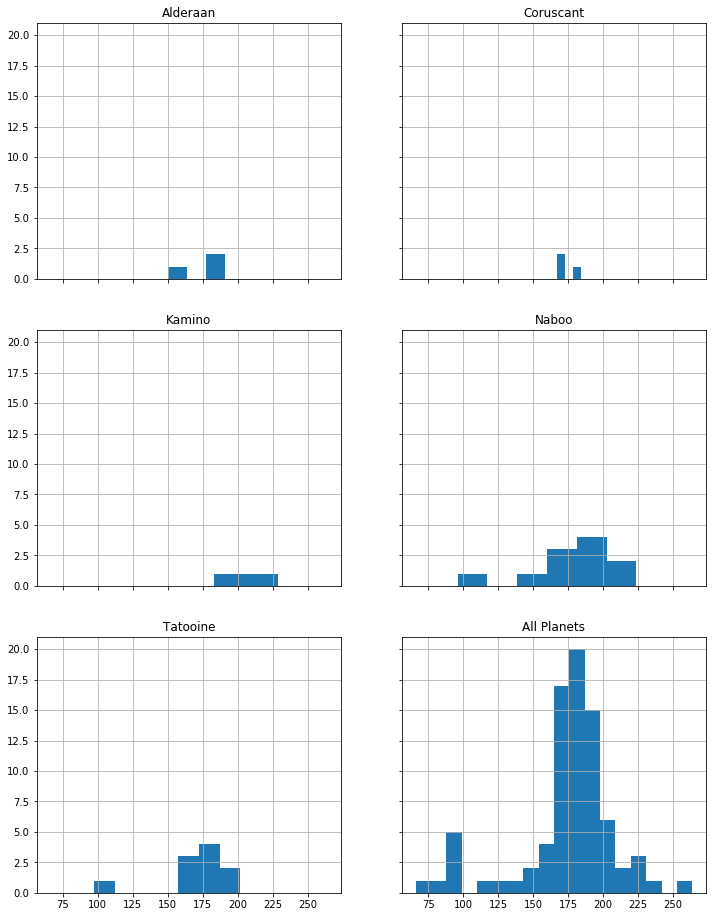

In [11]:
fig, ax_list = plt.subplots(3,2,sharex=True, sharey=True, figsize=(12,16))
for i, ax in zip(range(len(populous_worlds)), ax_list.ravel()):
    world=populous_worlds[i]
    world_index = union_not_nan_mask(df, 'homeworld','height', world)
    df.height[world_index].hist(bins='auto',ax=ax)
    ax.set_title(world)
fig.savefig('assets/images/height_vs_world.jpg')
plt.show()

### A little funky looking, but we can fix it up later.

In [12]:
np.linspace(75,250, 8)

array([ 75., 100., 125., 150., 175., 200., 225., 250.])

In [13]:
print_unique_counts(df,'species')

species                  counts                  |species                  counts              
------------------------------------------------------------------------
Human                    counts: 35              |Ewok                     counts: 1           
unknown                  counts: 5               |Muun                     counts: 1           
Droid                    counts: 5               |Mon Calamari             counts: 1           
Gungan                   counts: 3               |Togruta                  counts: 1           
Kaminoan                 counts: 2               |Yoda's species           counts: 1           
Mirialan                 counts: 2               |Xexto                    counts: 1           
Zabrak                   counts: 2               |Vulptereen               counts: 1           
Twi'lek                  counts: 2               |Trandoshan               counts: 1           
Wookiee                  counts: 2               |Toydarian    

In [14]:
species,species_count = get_unique_counts(df,'species')
common_species = list(species[np.where(species_count>2)][:-1]) + ['All Species']
common_species

['Droid', 'Gungan', 'Human', 'All Species']

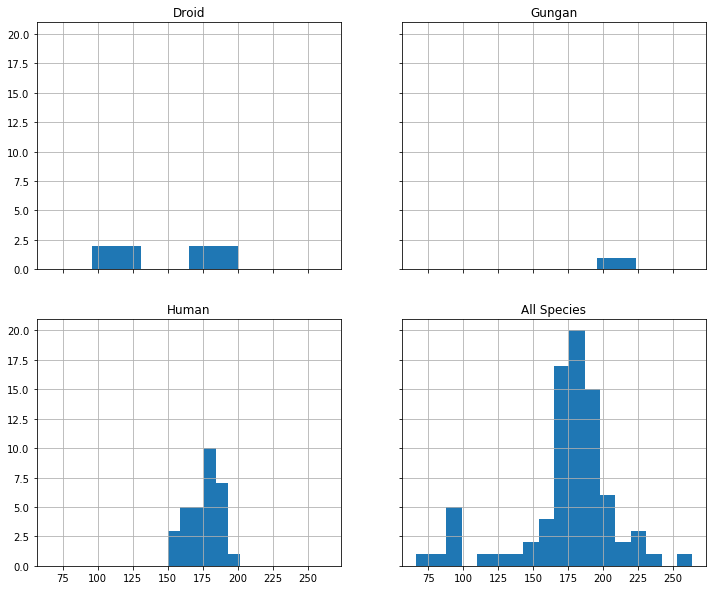

In [15]:
def make_basic_hists(df, col_list, x, y, w, h, f=(12,16)):
    fig, ax_list = plt.subplots(w,h,sharex=True, sharey=True, figsize=f)
    for i, ax in zip(range(len(col_list)), ax_list.ravel()):
        row_label = col_list[i]
        r_inx = union_not_nan_mask(df, x, y, row_label)
        df[y][r_inx].hist(bins='auto',ax=ax)
        ax.set_title(row_label)
    fig.savefig('assets/images/height_vs_species.jpg')
    plt.show()

make_basic_hists(df, common_species, 'species', 'height', 2, 2, f=(12,10))

Again: we can improve this a lot - but it's fine for now. 

# Question 2
The Original Trilogy and the Prequel Trilogy both featured men in leading roles and women in supporting roles, but the Sequel Trilogy features a leading woman. What is the distribution of genders across the films?

The api has 7 films. 

In [16]:
print(*[i for i in web_utilities.url_to_val_dict('films',v=False).values()], sep='\n')

A New Hope
Attack of the Clones
The Phantom Menace
Revenge of the Sith
Return of the Jedi
The Empire Strikes Back
The Force Awakens


In [17]:
movie_cols = ['A New Hope','The Empire Strikes Back','Return of the Jedi', 
              'The Phantom Menace','Attack of the Clones', 'Revenge of the Sith', 
              'The Force Awakens']

In [18]:
def get_gender_count(s):
    return [np.where(s == i)[0].shape[0] for i in ['male','female','no gender']]

i = movie_cols[0]
movie_mask =df[i]
s = df[movie_mask]['gender']
get_gender_count(s)

[12, 2, 3]

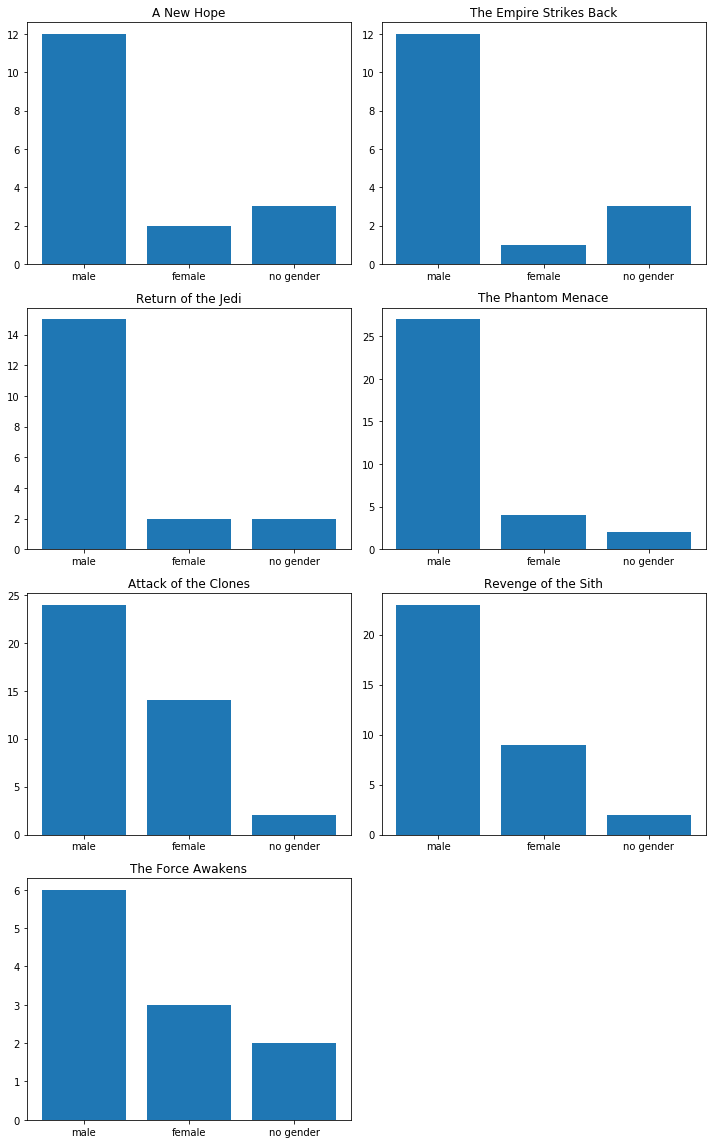

In [19]:
def get_gender_count(s):
    return [np.where(s == i)[0].shape[0] for i in ['male','female','no gender']]

movie_cols = ['A New Hope','The Empire Strikes Back','Return of the Jedi', 
              'The Phantom Menace','Attack of the Clones', 'Revenge of the Sith', 
              'The Force Awakens']
fig = plt.figure(figsize = (10,16))
ax = []
labels = ['male','female','no gender']
no_gender_count = 0
g_counts=[]
for v, i in enumerate(movie_cols):
    movie_mask = df[i]
    s = df[movie_mask]['gender']
    h = get_gender_count(s)
    g_counts.append(h+[i])
    ax.append(fig.add_subplot(4,2,v+1))
    ax[-1].bar(np.linspace(1,3,3), h, tick_label=labels)
    ax[-1].set_title(i)
    no_gender_count += h[2]
fig.tight_layout()
fig.savefig('assets/images/movie_vs_gender.jpg')

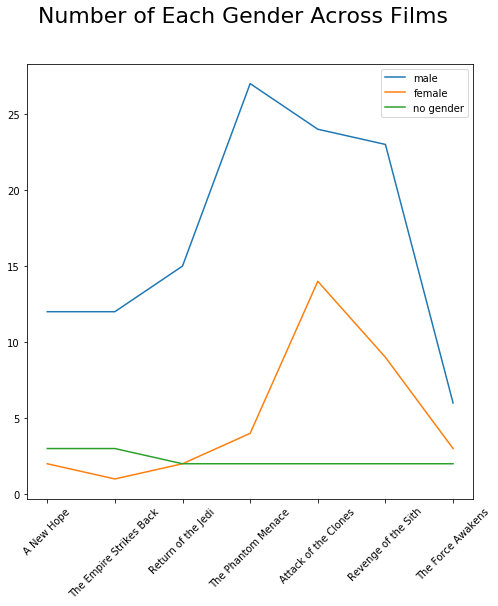

In [20]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
x = np.arange(0, len(movie_cols),1)
for i,g in zip(range(3), ['male','female','no gender']):
    y_vals = [j[i] for j in g_counts]
    plt.plot(x, y_vals, label=g)
plt.xticks(np.arange(0,len(movie_cols),1),movie_cols, rotation=45)
plt.suptitle('Number of Each Gender Across Films', fontsize=22)
plt.legend()
fig.savefig('assets/images/gender_film_lines.jpg')
plt.show()

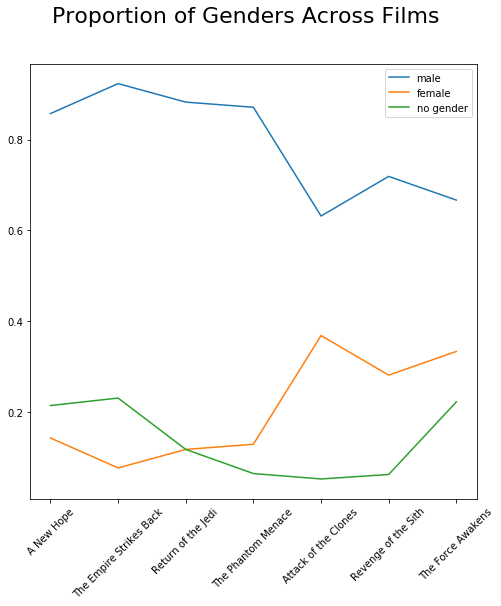

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
x = np.arange(0, len(movie_cols),1)
for i,g in zip(range(3), ['male','female','no gender']):
    y_vals = [j[i] / sum(j[:2]) for j in g_counts]
    plt.plot(x, y_vals, label=g)
plt.xticks(np.arange(0,len(movie_cols),1),movie_cols, rotation=45)
plt.suptitle('Proportion of Genders Across Films', fontsize=22)
plt.legend()
fig.savefig('assets/images/gender_film_lines2.jpg')
plt.show()

# Question 3 
Back to our difficult-to-explain interest in heights: can you find and visualize a linear regression that clearly explains the height of an individual? 

# Linear Regression
A lot of people sneer at linear regression because it isn't as shiny as the newer, more complicated models that are available. But linear regression has a lot of advantages, and it's often the best model for a problem.
- It's interpretable - an advantage that many more complicated models, such as neural networks, lack
- It's simple, which means it's easy to get up and running quickly

Linear regression has relatively high bias and low variance, which means that it's a little bit harder to overfit than some more complicated models. There is a limit though - and each variable that we add to our model will make it easier to overfit. It's probably a good idea to use just a few of these columns to fit our model. 

Additionally, we need to put our data into a form that our linear regression can "understand". If we want to use columns that have non-numerical values, first we'll need to transform them into numbers.

# Feature Engineering
"birth_year" and "mass" are the only variables that are are numerical. We'll need to transform the rest of our data to make it fit 
- eye_color - maybe I'll do "brown or blue" and "other"
- gender - the "Gender Across Films" graph above is a bit deceptive, since the same droids tend to appear across a lot of films. I'll do "male" and "female"
- hair_color - I'll make this "bald" and "not_bald"
- mass - this is fine (target leakage aside)
- skin_color - I'll say that everything that isn't "fair","light","dark" is an unusual skin color
- homeworld - skiping this one
- species - human and other


In [22]:
x_cols = ['birth_year', 'eye_color', 'gender', 'hair_color', 'mass',
          'skin_color', 'homeworld', 'species']
for i in x_cols:
    print_unique_counts(df, i, w=20)
    print('')

birth_year          counts             |birth_year          counts         
------------------------------------------------------------------------
-52.0               counts: 2          |-57.0               counts: 1      
-92.0               counts: 2          |-8.0                counts: 1      
-48.0               counts: 2          |-53.0               counts: 1      
-41.9               counts: 2          |-15.0               counts: 1      
-72.0               counts: 2          |-47.0               counts: 1      
-82.0               counts: 2          |-46.0               counts: 1      
-19.0               counts: 2          |-44.0               counts: 1      
-102.0              counts: 1          |-41.0               counts: 1      
-112.0              counts: 1          |-40.0               counts: 1      
-91.0               counts: 1          |-37.0               counts: 1      
-54.0               counts: 1          |-33.0               counts: 1      
-200.0         

In [23]:
def make_test_frame(df):
    lin_cols = ['height','birth_year','eyes_brown_blue','is_female',
                'is_bald','mass','is_human']
    df_x = pd.DataFrame(columns=lin_cols)
    df_x['height'] = df.height.copy()
    df_x['birth_year'] = df.birth_year.copy()
    df_x['mass'] = df.mass.copy()
    df_x['is_female'] = [i=='female' if i in ['male','female'] \
                         else np.nan for i in df.gender]
    df_x['is_bald'] = [True if i in ['none','no hair'] \
                       else False for i in df.hair_color]
    df_x['unusual_skin_color'] = [True if i not in ['fair','light', 'dark'] \
                                  else False for i in df.skin_color] 
    df_x['is_human'] = [i == 'Human' for i in df.species]
    df_x['eyes_brown_blue'] = [True if i in ['brown','blue'] \
                               else False for i in df.eye_color]
    return df_x

## Run 1
We can't perform a linear regression if we have missing values. There are a lot of ways to handle these - but the simplest is just to drop all the rows with NaNs. We'll try something fancier later if we have time.

In [24]:
df_x = make_test_frame(df)
df_x = df_x.dropna()
np.random.seed(1337)    # it's important to set the seed for reproducability 
                        # and to keep from just rerunning with different parameters
                        # until a "good score" is reached
if 'height' in df_x.columns:
    y = df_x.pop('height')
x_train, x_test, y_train, y_test = train_test_split(df_x, y)
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
print(df_x.shape,y.shape)
df_x.head()

(32, 7) (32,)


,birth_year,eyes_brown_blue,is_female,is_bald,mass,is_human,unusual_skin_color
0,-19.0,True,False,False,77,True,False
3,-41.9,False,False,True,136,True,True
4,-19.0,True,True,False,49,True,False
5,-52.0,True,False,False,120,True,False
6,-47.0,True,True,False,75,True,False


## Run 1 Results

For context, the R^2 score is: 

```(TSS (total sum of squares) - RSS (residual sum of squares)) / TSS```

A model that just guessed the average and disregarded the inputs would have an R^2 of 0, and the best possible model would be an R^2 of 1. A negative number means we're doing worse than if we just guessed the average.

That makes sense when we consider the small sample size (24 to train on, 8 for our test). We should see what we can do to drop fewer rows.

In [25]:
reg.score(x_test, y_test), len(x_train), len(x_test)

(-2.256947525171047, 24, 8)

In [26]:
for i,j in zip(reg.coef_, df_x.columns):
    print(j.ljust(20),i.round(2))

birth_year           0.05
eyes_brown_blue      -3.3
is_female            15.65
is_bald              -1.46
mass                 1.06
is_human             -19.52
unusual_skin_color   -14.12


For this model, "is_human", "unusual_skin_color", and "is_female" are the most significant factors

## Run 2

There are 44 entries that contain NaNs in the "birth_years" column. By dropping this column we can hold on to a lot more of our rows, and probably get better results.

In [27]:
df_x = make_test_frame(df)
if 'birth_year' in df_x.columns: df_x = df_x.drop('birth_year',axis=1)
df_x = df_x.dropna()
print(df_x.shape)
if 'height' in df_x.columns: y = df_x.pop('height')
x_train, x_test, y_train, y_test = train_test_split(df_x, y)
reg = LinearRegression().fit(x_train, y_train)

(54, 7)


## Run 2 Results 

This is already a lot better. By getting rid of the troublesome column, we've increased our sample size and improved our score immensely. 

I'd guess that this is about as good a result as we're likely to get. There are a ton of variables (and a ton of species).

In [28]:
reg.score(x_test, y_test), len(x_train), len(x_test)

(0.7929901233325982, 40, 14)

In [29]:
for i,j in zip(reg.coef_, df_x.columns):
    print(j.ljust(20),i.round(2))

eyes_brown_blue      -6.91
is_female            21.35
is_bald              4.71
mass                 1.0
is_human             -7.88
unusual_skin_color   -13.8


# Run 3
Let's try dropping mass just to see what that does...

In [30]:
df_x = make_test_frame(df)
if 'birth_year' in df_x.columns: df_x = df_x.drop('birth_year',axis=1)
if 'mass' in df_x.columns: df_x = df_x.drop('mass',axis=1)
df_x = df_x.dropna()
print(df_x.shape)
if 'height' in df_x.columns: y = df_x.pop('height')
x_train, x_test, y_train, y_test = train_test_split(df_x, y)
reg = LinearRegression().fit(x_train, y_train)

(76, 6)


In [31]:
reg.score(x_test, y_test), len(x_train), len(x_test)

(-0.04772383887914344, 57, 19)

Yeah, that seems about right. Mass is important.